# **DATA ANALYSIS FOR THE "CULTURAL EVOLUTION OF THE SELF" EXPERIMENT**

This notebook allows you to replicate the analyses reported in the paper: Wozniak, Charbonneau, Knoblich (2023) as well as further explore the collected data.

**Import necessary packages**

In [31]:
# Load packages
# Basic
import numpy as np
import pandas as pd
import scipy as sp
# Plotting
import matplotlib.pyplot as plt  # only import this one function from matplotlib
import seaborn as sns            # 
# Stats
import statsmodels as sm         # 
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
# Other
import pickle
import os                        # operating system
import glob

**Load the data**

In [83]:
# Load data
df_ALL = pd.read_csv('DATA_CultEvo_Chains.csv')
df_lmm = pd.read_csv('DATA_CultEvo_Chains_LMM_all.csv')
df_Occurr = pd.read_csv('DATA_CultEvo_Occurences.csv')
df_Valence = pd.read_csv('DATA_CultEvo_Valences.csv')
df_Line = pd.read_csv('DATA_CultEvo_LineScaleResponses.csv')

**Prepare the data**

In [4]:
# Prepare the data for plotting and analysis
# Create dictionaries with trait and valence labels
trait_valence_labels = {'Pos': 'Positive', 'Neu': 'Neutral', 'Neg': 'Negative'}
trait_labels = {
    'Add1': 'Attractive','Add2': 'Political','Add3': 'Religious',
    'Neg1': 'Corrupt','Neg2': 'Dishonest','Neg3': 'Lazy','Neg4': 'Without empathy','Neg5': 'Impolite','Neg6': 'Cowardly',
    'Neu1': 'Trendy','Neu2': 'Busy','Neu3': 'Traditional','Neu4': 'Predictable','Neu5': 'Introverted','Neu6': 'Mystical',
    'Pos1': 'Friendly','Pos2': 'Intelligent','Pos3': 'Honorable','Pos4': 'Skillful','Pos5': 'Charismatic','Pos6': 'Creative'
    }
# Inverted trait_labels dictionary
inv_map = {v: k for k, v in trait_labels.items()}
# List of traits from the dictionary
traits_list  = list(trait_labels.values())
traits_codes = list(trait_labels.keys())

# Prepare the valences data
df_Valence = df_Valence.loc[:,traits_list]
df_Valence['Negative'] = df_Valence.loc[:,['Corrupt','Dishonest','Lazy','Without empathy','Impolite','Cowardly']].mean(axis=1)
df_Valence['Neutral'] = df_Valence.loc[:,['Trendy','Busy','Traditional','Predictable','Introverted','Mystical']].mean(axis=1)
df_Valence['Positive'] = df_Valence.loc[:,['Friendly','Intelligent','Honorable','Skillful','Charismatic','Creative']].mean(axis=1)
val_summary = df_Valence.describe()    
val_median = df_Valence.median()

# Prepare the occurences data
occ_summary = df_Occurr.describe()    
occ_median = df_Occurr.median()

## TRANSMISSION CHAINS

### ANALYSIS OF TRANSMISSION CHAINS AT THE LEVEL OF ALL VALENCES

The results of the preregistered linear mixed model (LMM) analyses investigating the influence of group-association (ingroup versus outgroup) and valence of traits (positive, neutral, negative) on percentage of occurrence of these traits across generations. 

The exact values of statistics are different from the ones reported in the manuscript, because manusripts reports the results of analyses conducted with the LME4 package from R (which provides a more comprehensive output). However, the pattern of results revealed by both meythods is the same.

In [81]:
# Linear mixed model analysis for all valences
md = smf.mixedlm("Value ~ Group + Generation + Valence + Group*Generation*Valence", data=df_lmm, groups=df_lmm["Chain_id"])
mdf = md.fit()
display(mdf.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                     MixedLM         Dependent Variable:         Value     
No. Observations:          1188            Method:                     REML      
No. Groups:                18              Scale:                      38.1424   
Min. group size:           66              Log-Likelihood:             -3869.4676
Max. group size:           66              Converged:                  Yes       
Mean group size:           66.0                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                             50.026    1.012  49.423 0.000 48.042 52.010
Group[T.Ou]                            1.055    1.161   0.908 0.364 -1.221  3.331
Valence[T.Neu]                        -0.483    1.161  -0.416 0.678 -2.759  1.793
Valence[T.Pos]                        -1.109    1.161  -0.955 0.340 -3.385  1.167
Group[T.Ou]:Valence[T.Neu]            -0.173    1.642  -0.106 0.916 -3.392  3.045
Group[T.Ou]:Valence[T.Pos]            -1.412    1.642  -0.860 0.390 -4.631  1.806
Generation                            -1.599    0.139 -11.523 0.000 -1.871 -1.327
Group[T.Ou]:Generation                 0.127    0.196   0.647 0.517 -0.258  0.512
Generation:Valence[T.Neu]              0.397    0.196   2.024 0.043  0.013  0.782
Generation:Valence[T.Pos]              0.331    0.196   1.686 0.092 -0.054  0.716
Group[T.Ou]:Generation:Valence[T.Neu] -0.730    0.278  -2.629 0.009 -1.274 -0.186
Group[T.Ou]:Generation:Valence[T.Pos] -0.492    0.278  -1.772 0.076 -1.036  0.052
Group Var                              6.306    0.385                            
=================================================================================

"""

### ANALYSIS OF TRANSMISSION CHAINS AT THE LEVEL OF INDIVIDUAL VALENCES (POSITIVE, NEUTRAL, NEGATIVE)

Below you can see transmission chains for averages of traits representing three valences: positive, neutral, and negative. Green colour represents transmission chains for the minimal ingoup (your village), and red lines represent the minimal outgroup (strangers' village). Black start on the right represents the median frequency in general population, as indicated  by our additional survey.

**POSITIVE TRAITS**

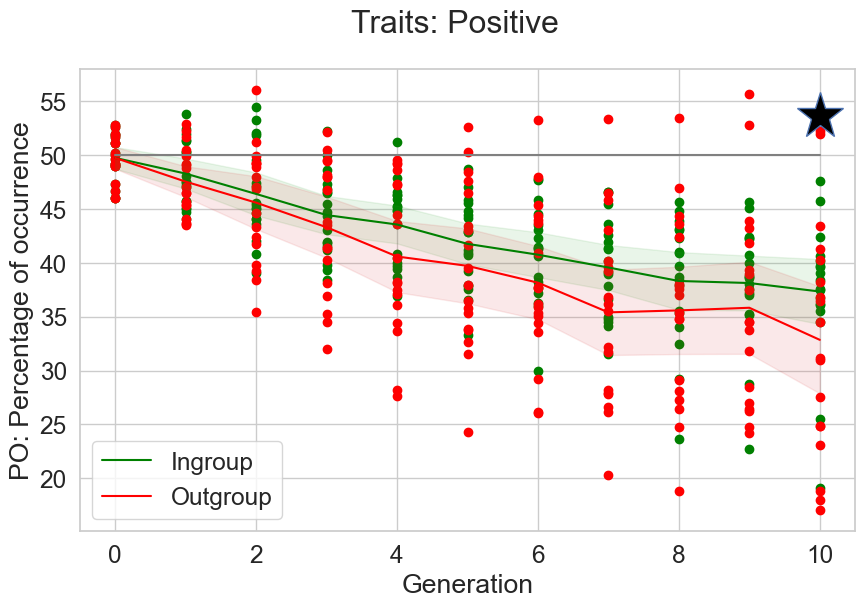

In [57]:
# Plot transmission chains for Positive valence
trait_valence = 'Pos'
# Rearrange the data
df_lmm2 = pd.melt(df_ALL, 
                    id_vars=['participant_exp_code', 'id_exp_chain', 'id_exp_participant'], 
                    value_vars=['Avg_In_'+trait_valence, 'Avg_Out_'+trait_valence], 
                    var_name ='group', 
                    value_name ='Avg_'+trait_valence)
df_lmm2['group'] = df_lmm2['group'].map({ 'Avg_In_'+trait_valence: 'Ingroup', 'Avg_Out_'+trait_valence: 'Outgroup' })

# Set plot style
sns.set(font_scale=1.6)
sns.set_style('whitegrid')
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)

# Produce Lineplot + Stripplot

# Add the 50% line
plt.plot([0, 10], [50, 50], color='grey')

# SCATTERPLOT
# SEABORN: ax1 = sns.stripplot(x="id_exp_participant", y='Avg_'+trait_valence, data=df_lmm2, hue='group', palette = ['g', 'r'] )
# Ingroup
x = df_lmm2.loc[ df_lmm2['group']=='Ingroup', 'id_exp_participant']
y = df_lmm2.loc[ df_lmm2['group']=='Ingroup', 'Avg_'+trait_valence]
ax1 = plt.scatter(x=x, y=y, color='green')
# Outgroup
x = df_lmm2.loc[ df_lmm2['group']=='Outgroup', 'id_exp_participant']
y = df_lmm2.loc[ df_lmm2['group']=='Outgroup', 'Avg_'+trait_valence]
ax1 = plt.scatter(x=x, y=y, color='red')

# LINEPLOT
# SEABORN: #ax1 = sns.lineplot(x='id_exp_participant', y='Avg_'+trait_valence, data=df_lmm2, hue='group', err_style='band', ci=95, palette = ['g', 'r'] )
# Ingroup
df_mean = df_lmm2.loc[ df_lmm2['group']=='Ingroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').mean().reset_index()
df_sd = df_lmm2.loc[ df_lmm2['group']=='Ingroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').describe().reset_index()
x = df_mean['id_exp_participant']
y = df_mean['Avg_'+trait_valence]
ax1 = plt.plot(x, y, color='green', label='Ingroup')
# Confidence interval
df_sd = df_lmm2.loc[ df_lmm2['group']=='Ingroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').describe().reset_index()
conf_int = (df_sd[('Avg_'+trait_valence,'std')] / np.sqrt(df_sd[('Avg_'+trait_valence,'count')]) ) * 1.96
plt.fill_between(x, y-conf_int, y+conf_int, alpha=0.1, color='tab:green')

# Outgroup
df_mean = df_lmm2.loc[ df_lmm2['group']=='Outgroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').mean().reset_index()
x = df_mean['id_exp_participant']
y = df_mean['Avg_'+trait_valence]
ax1 = plt.plot(x, y, color='red', label='Outgroup')
# Confidence interval
df_sd = df_lmm2.loc[ df_lmm2['group']=='Outgroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').describe().reset_index()
conf_int = (df_sd[('Avg_'+trait_valence,'std')] / np.sqrt(df_sd[('Avg_'+trait_valence,'count')]) ) * 1.96
plt.fill_between(x, y-conf_int, y+conf_int, alpha=0.1, color='tab:red')


# Other settings
trait_valence_labels = {'Pos': 'Positive', 'Neu': 'Neutral', 'Neg': 'Negative'}
#ax1.set(title='Traits: '+trait_valence_labels[trait_valence], xlabel='Generation', ylabel='FOT: Frequency of occurrence of a trait [%]')    
fig.suptitle('Traits: '+trait_valence_labels[trait_valence])
plt.xlabel('Generation')
plt.ylabel('PO: Percentage of occurrence')
plt.legend(loc="lower left")

# Add the point of believed occurrence in general population
plt.plot([10], [occ_median['Positive']], marker='*', ls='none', ms=35, markerfacecolor='black')

In [79]:
# LMM analysis for positive traits
df_lmm_pos = df_lmm[df_lmm['Valence'] == 'Pos']
md = smf.mixedlm("Value ~ Group + Generation + Group*Generation", data=df_lmm_pos, groups=df_lmm_pos["Chain_id"])
mdf = md.fit()
display(mdf.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    Value     
No. Observations:     396        Method:                REML      
No. Groups:           18         Scale:                 23.9480   
Min. group size:      22         Log-Likelihood:        -1213.3419
Max. group size:      22         Converged:             Yes       
Mean group size:      22.0                                        
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept              48.918    1.070  45.703 0.000 46.820 51.015
Group[T.Ou]            -0.358    0.920  -0.389 0.697 -2.161  1.446
Generation             -1.268    0.110 -11.533 0.000 -1.484 -1.053
Group[T.Ou]:Generation -0.365    0.156  -2.345 0.019 -0.670 -0.060
Group Var              13.001    1.010                            
==================================================================

"""

**NEUTRAL TRAITS**

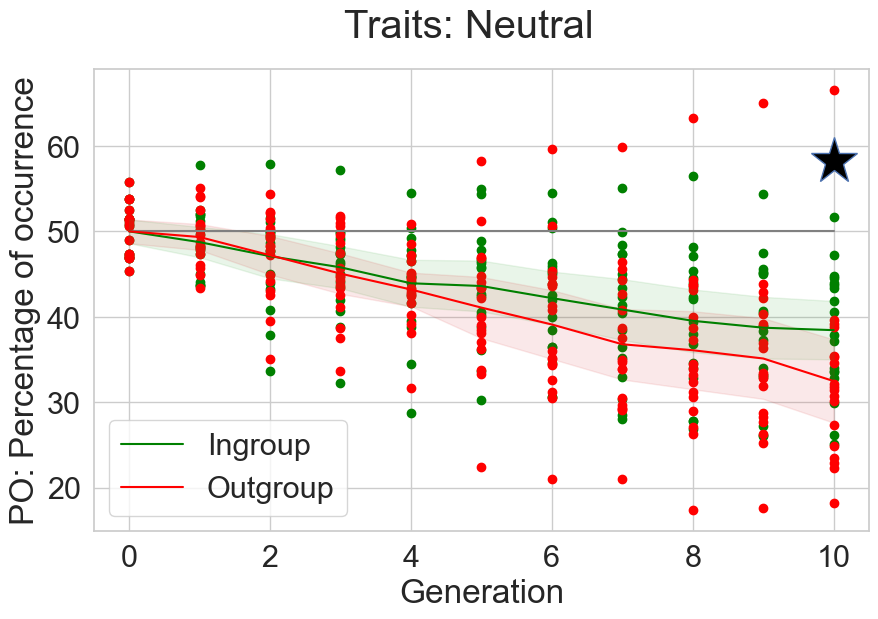

In [58]:
# Plot transmission chains for Neutral valence
trait_valence = 'Neu'
# Rearrange the data
df_lmm2 = pd.melt(df_ALL, 
                    id_vars=['participant_exp_code', 'id_exp_chain', 'id_exp_participant'], 
                    value_vars=['Avg_In_'+trait_valence, 'Avg_Out_'+trait_valence], 
                    var_name ='group', 
                    value_name ='Avg_'+trait_valence)
df_lmm2['group'] = df_lmm2['group'].map({ 'Avg_In_'+trait_valence: 'Ingroup', 'Avg_Out_'+trait_valence: 'Outgroup' })

# Set plot style
sns.set(font_scale=2)
sns.set_style('whitegrid')
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)

# Produce Lineplot + Stripplot

# Add the 50% line
plt.plot([0, 10], [50, 50], color='grey')

# SCATTERPLOT
# SEABORN: ax1 = sns.stripplot(x="id_exp_participant", y='Avg_'+trait_valence, data=df_lmm2, hue='group', palette = ['g', 'r'] )
# Ingroup
x = df_lmm2.loc[ df_lmm2['group']=='Ingroup', 'id_exp_participant']
y = df_lmm2.loc[ df_lmm2['group']=='Ingroup', 'Avg_'+trait_valence]
ax1 = plt.scatter(x=x, y=y, color='green')
# Outgroup
x = df_lmm2.loc[ df_lmm2['group']=='Outgroup', 'id_exp_participant']
y = df_lmm2.loc[ df_lmm2['group']=='Outgroup', 'Avg_'+trait_valence]
ax1 = plt.scatter(x=x, y=y, color='red')

# LINEPLOT
# SEABORN: #ax1 = sns.lineplot(x='id_exp_participant', y='Avg_'+trait_valence, data=df_lmm2, hue='group', err_style='band', ci=95, palette = ['g', 'r'] )
# Ingroup
df_mean = df_lmm2.loc[ df_lmm2['group']=='Ingroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').mean().reset_index()
df_sd = df_lmm2.loc[ df_lmm2['group']=='Ingroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').describe().reset_index()
x = df_mean['id_exp_participant']
y = df_mean['Avg_'+trait_valence]
ax1 = plt.plot(x, y, color='green', label='Ingroup')
# Confidence interval
df_sd = df_lmm2.loc[ df_lmm2['group']=='Ingroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').describe().reset_index()
conf_int = (df_sd[('Avg_'+trait_valence,'std')] / np.sqrt(df_sd[('Avg_'+trait_valence,'count')]) ) * 1.96
plt.fill_between(x, y-conf_int, y+conf_int, alpha=0.1, color='tab:green')

# Outgroup
df_mean = df_lmm2.loc[ df_lmm2['group']=='Outgroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').mean().reset_index()
x = df_mean['id_exp_participant']
y = df_mean['Avg_'+trait_valence]
ax1 = plt.plot(x, y, color='red', label='Outgroup')
# Confidence interval
df_sd = df_lmm2.loc[ df_lmm2['group']=='Outgroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').describe().reset_index()
conf_int = (df_sd[('Avg_'+trait_valence,'std')] / np.sqrt(df_sd[('Avg_'+trait_valence,'count')]) ) * 1.96
plt.fill_between(x, y-conf_int, y+conf_int, alpha=0.1, color='tab:red')



# Other settings
trait_valence_labels = {'Pos': 'Positive', 'Neu': 'Neutral', 'Neg': 'Negative'}
#ax1.set(title='Traits: '+trait_valence_labels[trait_valence], xlabel='Generation', ylabel='FOT: Frequency of occurrence of a trait [%]')    
fig.suptitle('Traits: '+trait_valence_labels[trait_valence])
plt.xlabel('Generation')
plt.ylabel('PO: Percentage of occurrence')
plt.legend(loc="lower left")

# Add the point of believed occurrence in general population
plt.plot([10], [occ_median['Neutral']], marker='*', ls='none', ms=35, markerfacecolor='black')

In [77]:
# LMM analysis for neutral traits
df_lmm_neu = df_lmm[df_lmm['Valence'] == 'Neu']
md = smf.mixedlm("Value ~ Group + Generation + Group*Generation", data=df_lmm_neu, groups=df_lmm_neu["Chain_id"])
mdf = md.fit()
display(mdf.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    Value     
No. Observations:    396        Method:                REML      
No. Groups:          18         Scale:                 29.3119   
Min. group size:     22         Log-Likelihood:        -1253.8251
Max. group size:     22         Converged:             Yes       
Mean group size:     22.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              49.544    1.227 40.378 0.000 47.139 51.948
Group[T.Ou]             0.881    1.018  0.866 0.387 -1.114  2.877
Generation             -1.202    0.122 -9.879 0.000 -1.440 -0.964
Group[T.Ou]:Generation -0.603    0.172 -3.502 0.000 -0.940 -0.265
Group Var              17.772    1.237                           
=================================================================

"""

**NEGATIVE TRAITS**

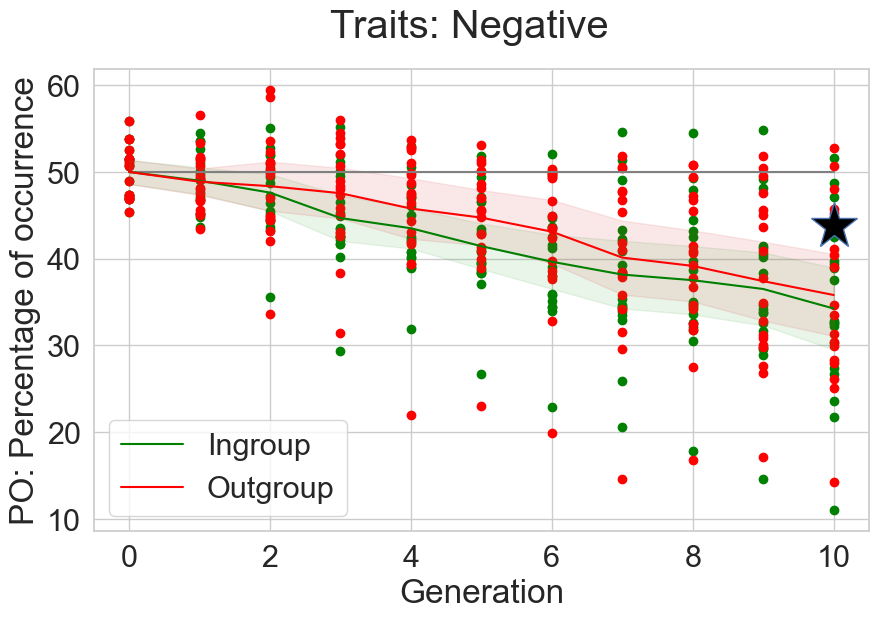

In [59]:
# Plot transmission chains for Negative valence
trait_valence = 'Neg'
# Rearrange the data
df_lmm2 = pd.melt(df_ALL, 
                    id_vars=['participant_exp_code', 'id_exp_chain', 'id_exp_participant'], 
                    value_vars=['Avg_In_'+trait_valence, 'Avg_Out_'+trait_valence], 
                    var_name ='group', 
                    value_name ='Avg_'+trait_valence)
df_lmm2['group'] = df_lmm2['group'].map({ 'Avg_In_'+trait_valence: 'Ingroup', 'Avg_Out_'+trait_valence: 'Outgroup' })

# Set plot style
sns.set(font_scale=2)
sns.set_style('whitegrid')
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)

# Produce Lineplot + Stripplot

# Add the 50% line
plt.plot([0, 10], [50, 50], color='grey')

# SCATTERPLOT
# SEABORN: ax1 = sns.stripplot(x="id_exp_participant", y='Avg_'+trait_valence, data=df_lmm2, hue='group', palette = ['g', 'r'] )
# Ingroup
x = df_lmm2.loc[ df_lmm2['group']=='Ingroup', 'id_exp_participant']
y = df_lmm2.loc[ df_lmm2['group']=='Ingroup', 'Avg_'+trait_valence]
ax1 = plt.scatter(x=x, y=y, color='green')
# Outgroup
x = df_lmm2.loc[ df_lmm2['group']=='Outgroup', 'id_exp_participant']
y = df_lmm2.loc[ df_lmm2['group']=='Outgroup', 'Avg_'+trait_valence]
ax1 = plt.scatter(x=x, y=y, color='red')

# LINEPLOT
# SEABORN: #ax1 = sns.lineplot(x='id_exp_participant', y='Avg_'+trait_valence, data=df_lmm2, hue='group', err_style='band', ci=95, palette = ['g', 'r'] )
# Ingroup
df_mean = df_lmm2.loc[ df_lmm2['group']=='Ingroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').mean().reset_index()
x = df_mean['id_exp_participant']
y = df_mean['Avg_'+trait_valence]
ax1 = plt.plot(x, y, color='green', label='Ingroup')
# Confidence interval
df_sd = df_lmm2.loc[ df_lmm2['group']=='Ingroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').describe().reset_index()
conf_int = (df_sd[('Avg_'+trait_valence,'std')] / np.sqrt(df_sd[('Avg_'+trait_valence,'count')]) ) * 1.96
plt.fill_between(x, y-conf_int, y+conf_int, alpha=0.1, color='tab:green')

# Outgroup
df_mean = df_lmm2.loc[ df_lmm2['group']=='Outgroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').mean().reset_index()
x = df_mean['id_exp_participant']
y = df_mean['Avg_'+trait_valence]
ax1 = plt.plot(x, y, color='red', label='Outgroup')
# Confidence interval
df_sd = df_lmm2.loc[ df_lmm2['group']=='Outgroup', ['id_exp_participant', 'Avg_'+trait_valence] ].groupby('id_exp_participant').describe().reset_index()
conf_int = (df_sd[('Avg_'+trait_valence,'std')] / np.sqrt(df_sd[('Avg_'+trait_valence,'count')]) ) * 1.96
plt.fill_between(x, y-conf_int, y+conf_int, alpha=0.1, color='tab:red')

# Other settings
trait_valence_labels = {'Pos': 'Positive', 'Neu': 'Neutral', 'Neg': 'Negative'}
#ax1.set(title='Traits: '+trait_valence_labels[trait_valence], xlabel='Generation', ylabel='FOT: Frequency of occurrence of a trait [%]')    
fig.suptitle('Traits: '+trait_valence_labels[trait_valence])
plt.xlabel('Generation')
plt.ylabel('PO: Percentage of occurrence')
plt.legend(loc="lower left")

# Add the point of believed occurrence in general population
plt.plot([10], [occ_median['Negative']], marker='*', ls='none', ms=35, markerfacecolor='black')

LMM analysis

In [76]:
# LMM analysis for negative traits
df_lmm_neg = df_lmm[df_lmm['Valence'] == 'Neg']
md = smf.mixedlm("Value ~ Group + Generation + Group*Generation", data=df_lmm_neg, groups=df_lmm_neg["Chain_id"])
mdf = md.fit()
display(mdf.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    Value     
No. Observations:     396        Method:                REML      
No. Groups:           18         Scale:                 33.7318   
Min. group size:      22         Log-Likelihood:        -1279.8508
Max. group size:      22         Converged:             Yes       
Mean group size:      22.0                                        
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept              50.026    1.239  40.382 0.000 47.598 52.454
Group[T.Ou]             1.055    1.092   0.966 0.334 -1.086  3.195
Generation             -1.599    0.131 -12.253 0.000 -1.855 -1.343
Group[T.Ou]:Generation  0.127    0.185   0.688 0.491 -0.235  0.489
Group Var              16.891    1.112                            
==================================================================

"""

### **ANALYSIS OF TRANSMISSION CHAINS AT THE LEVEL OF INDIVIDUAL TRAITS**

This segment allows you to explore the results for each individual trait. In order to do it select the trait in the next code cell by inputting its code. Here you can see the list of all codes:

| Positive | Code | Trait | Neutral | Code | Trait | Negative | Code | Trait | Additional | Code | Trait |
| --- | --- | --- | ---  | --- | --- | --- | --- | --- | --- | --- | --- |
| - | Pos1 | Friendly | - | Neu1 | Trendy | - | Neg1 | Corrupt | - | Add1 | Attractive |
| - | Pos2 | Intelligent | - | Neu2 | Busy | - | Neg2 | Dishonest | - | Add2 | Political |
| - | Pos3 | Honorable | - | Neu3 | Traditional | - | Neg3 | Lazy | - | Add3 | Religious |
| - | Pos4 | Skillful | - | Neu4 | Predictable | - | Neg4 | Without empathy | - | - | - |
| - | Pos5 | Charismatic | - | Neu5 | Introverted | - | Neg5 | Impolite | - | - | - |
| - | Pos6 | Creative | - | Neu6 | Mystical | - | Neg6 | Cowardly | - | - | - |



In [21]:
# SELECT YOUR CODE
trait = 'Add1'

In [23]:
# Preprocess the data
# Rearrange the data
df_lmm2 = pd.melt(df_ALL, 
                    id_vars=['participant_exp_code', 'id_exp_chain', 'id_exp_participant'], 
                    value_vars=[trait+'_In_response', trait+'_Out_response'], 
                    var_name ='group', 
                    value_name ='Avg_'+trait)

df_lmm2['group'] = df_lmm2['group'].map({ trait+'_In_response': 'Ingroup', trait+'_Out_response': 'Outgroup' })
    

In [25]:
# Set plot style
sns.set(font_scale=2)
sns.set_style('whitegrid')

PLOT THE AVERAGES OF TRANSMISSION CHAIN

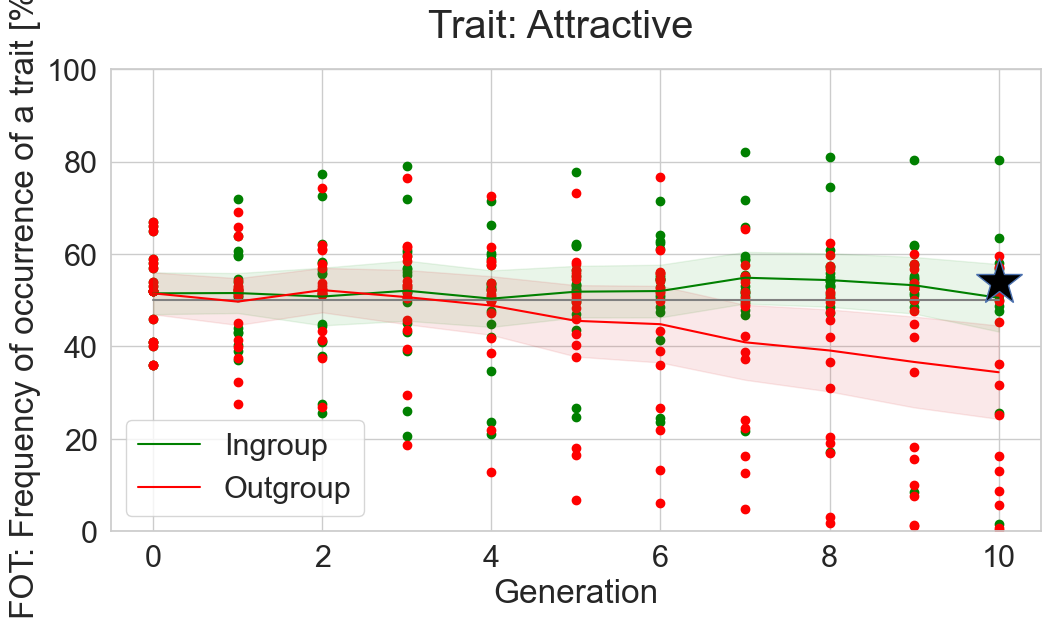

In [26]:
# Plot lineplot with scatterplot
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)

# Add the 50% line
plt.plot([0, 10], [50, 50], color='grey')

# SCATTERPLOT
# SEABORN: ax1 = sns.stripplot(x="id_exp_participant", y='Avg_'+trait, data=df_lmm2, hue='group', palette = ['g', 'r'] )
# Ingroup
x = df_lmm2.loc[ df_lmm2['group']=='Ingroup', 'id_exp_participant']
y = df_lmm2.loc[ df_lmm2['group']=='Ingroup', 'Avg_'+trait]
ax1 = plt.scatter(x=x, y=y, color='green')
# Outgroup
x = df_lmm2.loc[ df_lmm2['group']=='Outgroup', 'id_exp_participant']
y = df_lmm2.loc[ df_lmm2['group']=='Outgroup', 'Avg_'+trait]
ax1 = plt.scatter(x=x, y=y, color='red')


# LINEPLOT
# SEABORN: #ax1 = sns.lineplot(x='id_exp_participant', y='Avg_'+trait, data=df_lmm2) #, hue='group') #, err_style='band', ci=95, palette = ['g', 'r'] )
# Ingroup
df_mean = df_lmm2.loc[ df_lmm2['group']=='Ingroup', ['id_exp_participant', 'Avg_'+trait] ].groupby('id_exp_participant').mean().reset_index()    
x = df_mean['id_exp_participant']
y = df_mean['Avg_'+trait]
ax1 = plt.plot(x, y, color='green', label='Ingroup')

df_sd = df_lmm2.loc[ df_lmm2['group']=='Ingroup', ['id_exp_participant', 'Avg_'+trait] ].groupby('id_exp_participant').describe().reset_index()
conf_int = (df_sd[('Avg_'+trait,'std')] / np.sqrt(df_sd[('Avg_'+trait,'count')]) ) * 1.96
plt.fill_between(x, y-conf_int, y+conf_int, alpha=0.1, color='tab:green')
# Outgroup
df_mean = df_lmm2.loc[ df_lmm2['group']=='Outgroup', ['id_exp_participant', 'Avg_'+trait] ].groupby('id_exp_participant').mean().reset_index()
x = df_mean['id_exp_participant']
y = df_mean['Avg_'+trait]
ax1 = plt.plot(x, y, color='red', label='Outgroup')

df_sd = df_lmm2.loc[ df_lmm2['group']=='Outgroup', ['id_exp_participant', 'Avg_'+trait] ].groupby('id_exp_participant').describe().reset_index()
conf_int = (df_sd[('Avg_'+trait,'std')] / np.sqrt(df_sd[('Avg_'+trait,'count')]) ) * 1.96
plt.fill_between(x, y-conf_int, y+conf_int, alpha=0.1, color='tab:red')

# Adjust the figure
plt.ylim([0,100])
fig.suptitle('Trait: '+trait_labels[trait])
plt.xlabel('Generation')
plt.ylabel('FOT: Frequency of occurrence of a trait [%]')
plt.legend(loc="lower left")
#ax1.set(title='Trait: '+trait_labels[trait], xlabel='Generation', ylabel='FOT [%]')

# Add the point of believed occurrence in general population
plt.plot([10], [occ_median[trait_labels[trait]]], marker='*', ls='none', ms=35, markerfacecolor='black')

PLOT THE TRAJECTORIES OF TRANSMISSION CHAINS IN VECTOR SPACE

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100')])

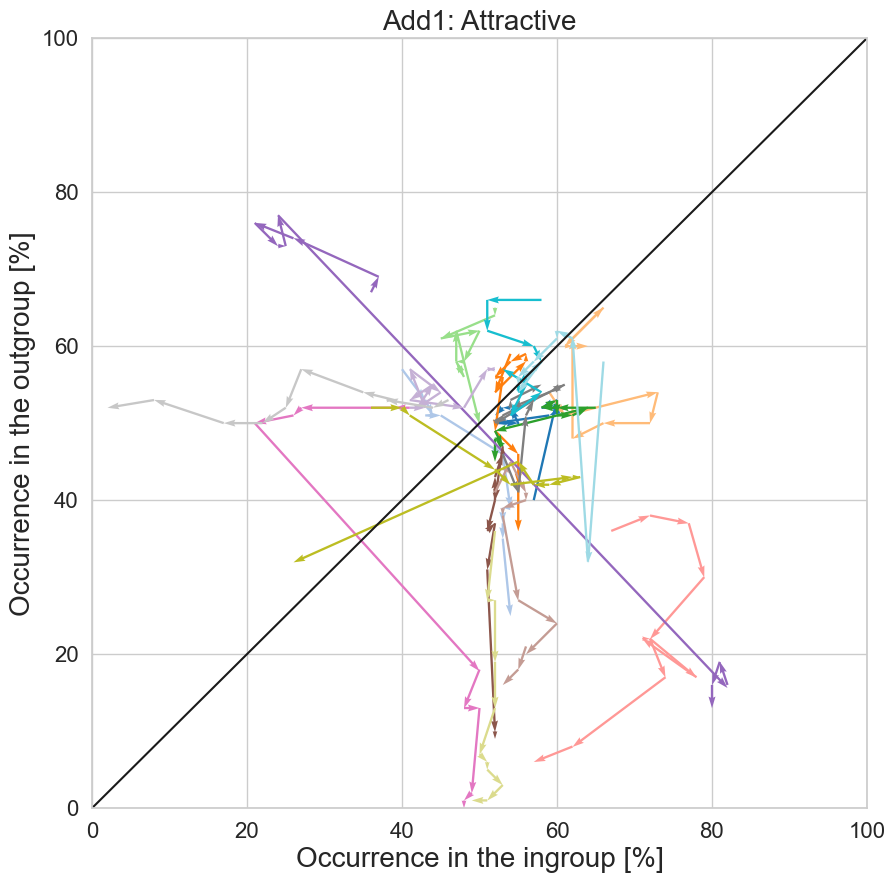

In [28]:
# Plot the trajectories in vector space 
# Prepare the vector data
x = df_ALL[trait+'_In_correct_response']
y = df_ALL[trait+'_Out_correct_response']
u = df_ALL[trait+'_In_response'].round() - df_ALL[trait+'_In_correct_response']
v = df_ALL[trait+'_Out_response'].round() - df_ALL[trait+'_Out_correct_response']

c = df_ALL['id_exp_chain']

#arrow_widths = np.sqrt( (u)**2+(v)**2 )/40
arrow_widths = 0.003

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = [10, 10]
#fig = plt.figure()
plt.xlim([0, 100])
plt.ylim([0, 100])
# draw vertical line from (70,100) to (70, 250)
plt.plot([0, 100], [0, 100], 'k-')
ax = plt.quiver(x,y,u,v,c, cmap='tab20', width=arrow_widths, scale=100) #, linewidths=arrow_widths)
# Axes labels
# Which trait
plt.xlabel('Occurrence in the ingroup [%]', fontsize=20) # , fontsize=24)
plt.ylabel('Occurrence in the outgroup [%]', fontsize=20)
plt.title(trait+': '+trait_labels[trait], fontsize=20)
# Set tick font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


TABLE: Average percentage of occurrence in each generation

In [30]:
# Calculate and print table
averages = df_lmm2.groupby(['group', 'id_exp_participant']).mean()['Avg_'+trait].reset_index()
averages = pd.pivot(averages, index='group', columns='id_exp_participant')
averages.columns = averages.columns.droplevel(0)
# Display the table
display(averages)

id_exp_participant,0,1,2,3,4,5,6,7,8,9,10
group,,,,,,,,,,,
Ingroup,51.5,51.562657,50.796296,52.069273,50.345679,51.853909,51.993045,54.876543,54.362346,53.246914,50.526537
Outgroup,51.5,49.704632,52.197531,50.674211,48.851852,45.545267,44.820205,40.901235,39.127778,36.644033,34.421603


ANALYZE THE DATA USING LINEAR MIXED MODEL

In [32]:
# LMM analysis 
df_lmm = df_lmm2.rename({'participant_exp_code':'Participant', 'id_exp_chain':'Chain', 'id_exp_participant':'Generation', 'group':'Group', 'Avg_'+trait:'Average'}, axis=1) 
# Specify the model
md = smf.mixedlm("Average ~ Group + Generation + Group*Generation", data=df_lmm, groups=df_lmm["Chain"]) # , vc_formula = {"Generation" : "0"})

# Model with random slope and intercept - with uncorrelated random slope and intercept
#md = smf.mixedlm("Average ~ Group + Generation + Group*Generation", data=df_lmm, groups=df_lmm["Chain"], vc_formula = {"Generation" : "0 + Generation"})
# Model with random slope and intercept - with correlated random slope and intercept
#md = smf.mixedlm("Average ~ Group + Generation + Group*Generation", data=df_lmm, groups=df_lmm["Chain"], vc_formula = {"Generation" : "1 + Generation"})

# Fit the model
mdf = md.fit()

# Display the results
display(mdf.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM      Dependent Variable:      Average   
No. Observations:      396          Method:                  REML      
No. Groups:            18           Scale:                   154.0752  
Min. group size:       22           Log-Likelihood:          -1574.6290
Max. group size:       22           Converged:               Yes       
Mean group size:       22.0                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    51.202    2.375 21.559 0.000 46.547 55.857
Group[T.Outgroup]             2.853    2.334  1.222 0.222 -1.722  7.427
Generation                    0.180    0.279  0.646 0.518 -0.366  0.727
Group[T.Outgroup]:Generation -2.002    0.395 -5.075 0.000 -2.775 -1.229
Group Var                    52.505    1.681                           
=======================================================================

"""

Additional information

In [35]:
# Display table showing the number of flips
t = df_ALL[trait+'_InOut_change_YesNo'].value_counts()
t = t.rename({0:'No flip', 1:'Flip: Ingroup becomes bigger', -1:'Flip: Outgroup becomes bigger', 3:'Values were the same'}, axis=0)
t = t.sort_index()
# Display
display(pd.DataFrame(t))

,Add1_InOut_change_YesNo
Flip: Ingroup becomes bigger,5
Flip: Outgroup becomes bigger,3
No flip,166
Values were the same,6


A table showing the number of chains that finished close to each attractor, as determined by k-means cluster analysis. The clusters are:
- ingroup 10% - outgroup 10%
- ingroup 10% - outgroup 50%
- ingroup 50% - outgroup 10%
- ingroup 50% - outgroup 50%

In [36]:
# # CLUSTERING
filename = "CultEvo_kmeans.pickle"
kmeans = pickle.load(open(filename, "rb"))
X = df_ALL.loc[df_ALL['id_exp_participant']==10,:].loc[:,[trait+'_In_response', trait+'_Out_response']]
X = X.rename({
    trait+'_In_response':'In_Gen10',
    trait+'_Out_response':'Out_Gen10'
    }, axis=1)
y_predict = kmeans.predict(X)
cluster_centers = kmeans.cluster_centers_

clusters_table = np.array([
    [np.count_nonzero(y_predict == 1), np.count_nonzero(y_predict == 2)],
    [np.count_nonzero(y_predict == 3), np.count_nonzero(y_predict == 0)]
    ])
df_clusters = pd.DataFrame(clusters_table, 
                           index=['Outgroup = 50%', 'Outgroup = 10%'], 
                           columns=['Ingroup = 10%', 'Ingroup = 50%'])

display(df_clusters)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,Ingroup = 10%,Ingroup = 50%
Outgroup = 50%,1,9
Outgroup = 10%,1,7


## PRE-STUDY: TRAITS - ESTIMATED VALENCE

In order to select the traits to be used in the transmission chains experiment we conducted a study in which we asked 26 participants from Prolific to rate 72 preselected traits on a scale from 1 (very negative) to 7 (very positive). Below we present the results for traits that were used in the transmission chain experiment.

In [43]:
# Prepare the table
traits_tab = val_summary#.iloc[:,2:23]
traits_tab = traits_tab.loc[['mean', 'std', '25%', '50%', '75%'],:].transpose().round(2)

print('POSITIVE TRAITS:')
display(traits_tab.iloc[15:21,:].style.format("{:.2f}"))
print('NEUTRAL TRAITS:')
display(traits_tab.iloc[9:15,:].style.format("{:.2f}"))
print('NEGATIVE TRAITS:')
display(traits_tab.iloc[3:9,:].style.format("{:.2f}"))
print('ADDITIONAL TRAITS:')
display(traits_tab.iloc[0:3,:].style.format("{:.2f}"))

POSITIVE TRAITS:


,mean,std,25%,50%,75%
Friendly,6.31,0.62,6.00,6.00,7.00
Intelligent,6.42,0.58,6.00,6.00,7.00
Honorable,6.27,0.72,6.00,6.00,7.00
Skillful,6.31,0.79,6.00,6.50,7.00
Charismatic,6.00,0.80,6.00,6.00,6.75
Creative,6.15,0.73,6.00,6.00,7.00


NEUTRAL TRAITS:


,mean,std,25%,50%,75%
Trendy,4.35,1.26,4.00,4.50,5.00
Busy,4.04,1.15,3.00,4.00,4.75
Traditional,4.35,1.32,4.00,4.00,5.00
Predictable,4.23,1.34,3.00,4.00,5.00
Introverted,3.81,1.20,3.00,4.00,4.00
Mystical,4.19,0.98,4.00,4.00,5.00


NEGATIVE TRAITS:


,mean,std,25%,50%,75%
Corrupt,1.38,0.64,1.00,1.00,2.00
Dishonest,1.46,0.58,1.00,1.00,2.00
Lazy,2.12,0.99,1.00,2.00,3.00
Without empathy,1.96,0.87,1.00,2.00,2.00
Impolite,1.62,0.57,1.00,2.00,2.00
Cowardly,2.08,0.93,1.00,2.00,3.00


ADDITIONAL TRAITS:


,mean,std,25%,50%,75%
Attractive,5.54,1.17,5.00,6.00,6.00
Political,3.62,1.44,3.00,4.00,4.00
Religious,3.54,1.70,2.25,4.00,4.00


Display average ratings for each category

[Text(1, 0, 'Negative'), Text(2, 0, 'Neutral'), Text(3, 0, 'Positive')]

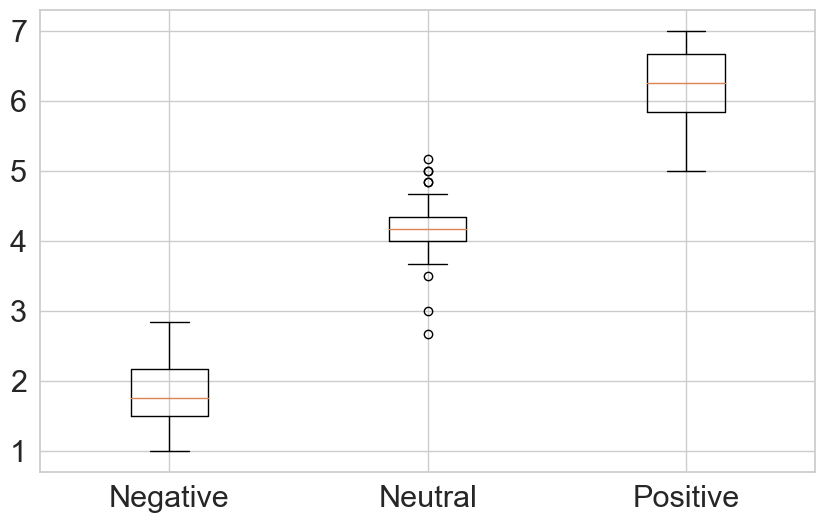

In [46]:
# Plot average ratings
data_occ = df_Valence[['Negative', 'Neutral', 'Positive']]
fig, ax = plt.subplots()
sns.set(font_scale=2)
sns.set_style('whitegrid')
fig.set_size_inches(10, 6)
plt.boxplot(data_occ[['Negative', 'Neutral', 'Positive']])
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])#, fontsize=20)

## CONTROL EXPERIMENT 1: TRAITS - ESTIMATED OCCURRENCE IN GENERAL POPULATION

Control experiment 1 investigated what are the beliefs about the percentage of occurrence in general population of traits used in the transmission chain experiment. They were measured on a percentage scale from 0% ("Nobody" possesses this trait) to 100% ("Everybody" possesses this trait).

In [47]:
 # Prepare the data and display the tables
traits_tab = occ_summary.iloc[:,2:23]
traits_tab = traits_tab.loc[['mean', 'std', '25%', '50%', '75%'],:].transpose().round(2)

print('POSITIVE TRAITS:')
display(traits_tab.iloc[15:21,:].style.format("{:.2f}"))
print('NEUTRAL TRAITS:')
display(traits_tab.iloc[9:15,:].style.format("{:.2f}"))
print('NEGATIVE TRAITS:')
display(traits_tab.iloc[3:9,:].style.format("{:.2f}"))
print('ADDITIONAL TRAITS:')
display(traits_tab.iloc[0:3,:].style.format("{:.2f}"))

POSITIVE TRAITS:


,mean,std,25%,50%,75%
Friendly,64.06,16.08,54.00,65.00,76.00
Intelligent,53.41,17.79,40.00,50.00,69.00
Honorable,48.75,16.11,38.00,50.00,60.00
Skillful,57.22,16.39,50.00,59.00,70.00
Charismatic,46.45,16.40,35.50,50.00,55.00
Creative,52.75,18.73,40.00,55.00,66.00


NEUTRAL TRAITS:


,mean,std,25%,50%,75%
Trendy,48.94,16.15,37.50,46.00,61.00
Busy,67.27,15.91,55.00,70.00,78.50
Traditional,53.04,18.89,40.00,50.00,70.00
Predictable,65.04,15.53,50.00,65.00,79.00
Introverted,49.84,12.80,42.50,50.00,57.50
Mystical,32.14,18.00,20.00,30.00,41.50


NEGATIVE TRAITS:


,mean,std,25%,50%,75%
Corrupt,43.12,24.22,25.50,36.00,60.00
Dishonest,49.10,22.20,31.00,45.00,65.00
Lazy,52.55,17.22,39.50,50.00,70.00
Without empathy,39.45,21.91,20.50,34.00,59.50
Impolite,44.25,18.30,31.50,44.00,54.00
Cowardly,51.57,16.97,40.00,57.00,61.00


ADDITIONAL TRAITS:


,mean,std,25%,50%,75%
Attractive,54.45,20.85,40.00,54.00,70.00
Political,52.00,19.92,36.50,52.00,68.50
Religious,50.96,19.64,36.00,50.00,64.00


Plot the averages

[Text(1, 0, 'Negative'), Text(2, 0, 'Neutral'), Text(3, 0, 'Positive')]

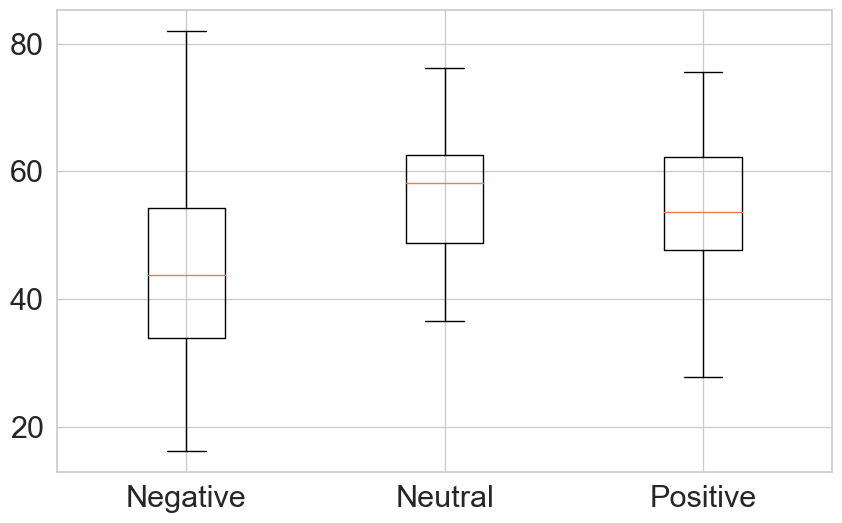

In [49]:
# Plot the averages
data_occ = df_Occurr[['Negative', 'Neutral', 'Positive']]
fig, ax = plt.subplots()
sns.set(font_scale=2)
sns.set_style('whitegrid')
fig.set_size_inches(10, 6)
plt.boxplot(data_occ[['Negative', 'Neutral', 'Positive']])
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])#, fontsize=20)

Perform ANOVA testing for the main effect of valence

In [53]:
# Perform ANOVA
from statsmodels.stats.anova import AnovaRM
data_long = pd.melt(df_Occurr, 
                    id_vars='participant_num', 
                    value_vars=['Negative', 'Neutral', 'Positive'], 
                    var_name='Valence', value_name='Occurrence')

resA = AnovaRM(data=data_long, 
                depvar='Occurrence', 
                subject='participant_num', 
                within=['Valence']).fit()    

print(resA)

                Anova
        F Value Num DF  Den DF  Pr > F
--------------------------------------
Valence 12.4839 2.0000 100.0000 0.0000



Test whether believed occurrences correlate with values at Generation 10

In [55]:
 # Display correlation with generation 10
df_gen10 = df_ALL.loc[df_ALL['id_exp_participant']==10]
# Ingroup data
gen10_in = df_gen10.loc[:,[i+'_In_response' for i in traits_codes] ]
dict_in = { list(gen10_in.columns)[i]: traits_list[i] for i in range(len(traits_list)) }
gen10_in.rename(columns=dict_in, inplace=True)
gen10_in = gen10_in.mean()
# Outgroup data
gen10_out = df_gen10.loc[:,[i+'_Out_response' for i in traits_codes] ]
dict_out = { list(gen10_out.columns)[i]: traits_list[i] for i in range(len(traits_list)) }
gen10_out.rename(columns=dict_out, inplace=True)
gen10_out = gen10_out.mean()

# Occurence data
df_occurence = occ_median[2:23,]

# Concatenate
df_occ_corr = pd.concat([df_occurence, gen10_in, gen10_out], axis=1)
df_occ_corr.rename(columns={ 0:'Occurence', 1:'Generation 10: Ingroup', 2:'Generation 10: Outgroup' }, inplace=True)

display((df_occ_corr.corr().style.format("{:.2f}")))

,Occurence,Generation 10: Ingroup,Generation 10: Outgroup
Occurence,1.00,0.17,0.02
Generation 10: Ingroup,0.17,1.00,0.05
Generation 10: Outgroup,0.02,0.05,1.00


## CONTROL EXPERIMENT 2: NUMBER-TO-LINE ESTIMATION TASK

Control experiment 2 investigated whether performing a simple number-to-position task leads to a similar response bias to the one that we observed in our transmission chains experiment. 30 participants completed this study on Prolific. It consisted of 99 trials in which participants were presented with all numbers between 1% and 99% and were told to indicate this number on a line. The numbers were presented in random order.

In [102]:
# Descriptive statistics of how strongly people deviated from the target for each decimal number - for example, decimal number 2 means that for all target numbers between 20 and 29.
df_Line['Decimal number'] = df_Line['Grid10']
summary = df_Line[['Decimal number','Response difference']].groupby(by='Decimal number').describe()
display(summary)

Response difference                                           \
                             count      mean       std        min       25%   
Decimal number                                                                
0                            270.0 -1.685597  2.059492  -7.444444 -2.888889   
1                            300.0 -3.651852  3.734172 -14.222222 -6.138889   
2                            300.0 -4.503704  4.608235 -21.555556 -7.805556   
3                            300.0 -6.390370  5.728656 -31.111111 -9.777778   
4                            300.0 -2.430741  5.555156 -36.444444 -3.555556   
5                            300.0 -0.867778  2.170393  -7.222222 -2.000000   
6                            300.0 -0.582222  4.778874 -29.555556 -3.111111   
7                            300.0  0.891852  4.584786 -10.666667 -1.555556   
8                            300.0 -0.174444  4.015009 -11.000000 -2.611111   
9                            300.0  0.049630  2.493545 -15.111111 -0.777778   

                                               
                     50%       75%        max  
Decimal number                                 
0              -1.444444 -0.444444   7.000000  
1              -3.222222 -1.222222   9.333333  
2              -3.666667 -1.111111   9.666667  
3              -5.333333 -2.111111   5.555556  
4              -0.777778  0.555556   5.555556  
5              -0.777778  0.361111   9.333333  
6              -0.777778  1.666667  16.444444  
7               0.888889  3.722222  21.222222  
8               0.388889  2.555556  10.555556  
9               0.333333  1.333333   6.555556

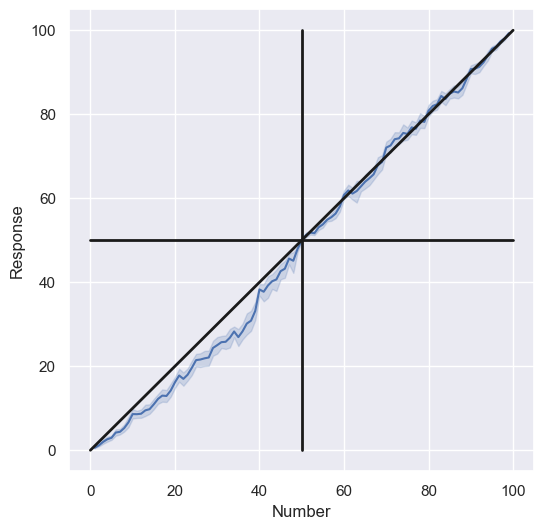

In [93]:
# Lineplot showing target and average indicated number
sns.set(rc={'figure.figsize':(6,6)})
sns.lineplot(data=df_Line, x='Number', y='Response', estimator='mean', errorbar=('ci', 95)) #, color = 'r', line_kws={'lw':2, 'color': 'b'})
plt.plot([0, 100], [0, 100], '-', color = 'k', lw = 2)
plt.plot([0, 100], [50, 50], '-', color = 'k', lw = 2)
plt.plot([50, 50], [0, 100], '-', color = 'k', lw = 2)

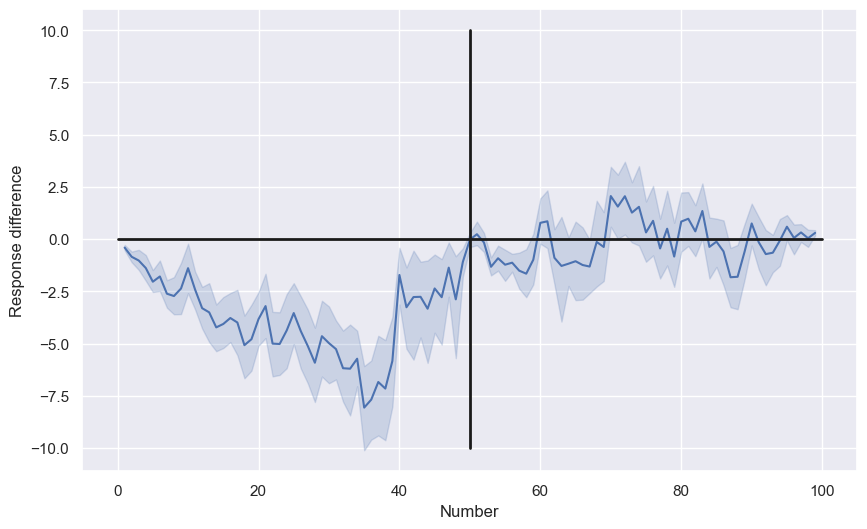

In [88]:
# Lineplot showing deviations from target responses
sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(data=df_Line, x='Number', y='Response difference', estimator='mean', errorbar=('ci', 95)) #, color = 'r', line_kws={'lw':2, 'color': 'b'})
plt.plot([0, 100], [0, 0], '-', color = 'k', lw = 2)
plt.plot([50, 50], [-10, 10], '-', color = 'k', lw = 2)

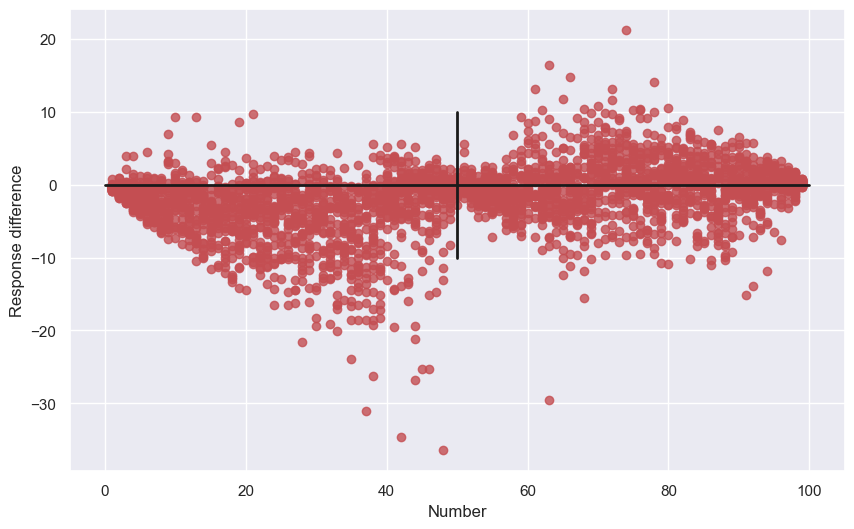

In [97]:
# Scatter plot showing deviations from target for all individual responses
sns.set(rc={'figure.figsize':(10,6)})
sns.regplot(data=df_Line, x='Number', y='Response difference', fit_reg=False, order=5, color = 'r', line_kws={'lw':2, 'color': 'b'})
plt.plot([0, 100], [0, 0], '-', color = 'k', lw = 2)
plt.plot([50, 50], [-10, 10], '-', color = 'k', lw = 2)